#Import nessessary libraries 

In [1]:
import numpy as np
import tensorflow as tf
import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# Adapted from https://github.com/ageron/handson-ml2
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label = "Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

#Data

##Generate data

The function below generates `num_of_sample` samples of a wave form in the interval from $0$ to $1$ (second).The waveform is the superposition of four sine waves with different frequencies and time offsets.

In [3]:
def generate_time_series(num_of_sample, second):

    freq1, freq2, freq3, freq4, offs1, offs2, offs3, offs4 = np.random.rand(8, 1)
    time = np.linspace(0, second, num_of_sample)

    wave1 = 0.5 * np.sin((time - offs1) * (freq1 * 10 + 10))  
    wave2 = 0.2 * np.sin((time - offs2) * (freq2 * 20 + 20)) 
    wave3 = - 0.7 * np.sin((time - offs3) * (freq3 * 30 + 30)) 
    wave4 = 0.6 * np.sin((time - offs4) * (freq4 * 40 + 40)) 
    
    noise = 0.1 * (np.random.rand(1, num_of_sample) - 0.5)  

    data = wave1 + wave2 + wave3 + wave4 + noise
    return data

In [4]:
np.random.seed(1010)
num_of_sample = 10000
data = generate_time_series(num_of_sample, 10)

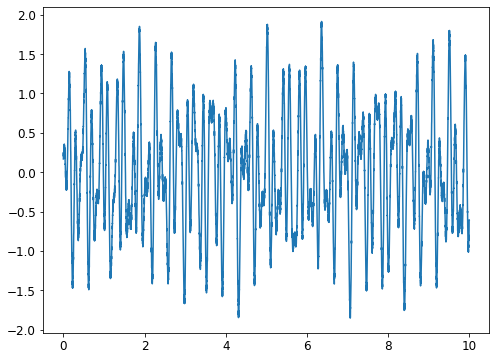

In [5]:
# plot the data
plt.figure(figsize = (8, 6))
plt.plot(np.linspace(0, 10, num_of_sample), data[0])
plt.show()

##Pre-process data

###Split the data into training and test sets.

###Activity 1: Prepare the training data set

In this activity, we are writing a function called `split_sequence()`. This function required two inputs:

- `sequence`: your time series

- `window_length`: the length of the sliding window

- `step_ahead`: number of samples in future

The function returns: `X` and `y`

In [6]:
def split_sequence(sequence, window_length, step_ahead):
  X, y = list(), list()

  for i in range(len(sequence)):
    if (i+window_length+step_ahead)>(len(sequence)):
      break
    X_temp, y_temp = sequence[i:i+window_length],sequence[i+window_length:i+window_length+step_ahead]
    X.append(X_temp)
    y.append(y_temp)

  return np.asarray(X), np.asarray(y)   

####Test `split_sequence()`

Run the below cell and check your result. 

In [7]:
raw_seq = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
window_length = 3
step_ahead = 4

X, y = split_sequence(raw_seq, window_length, step_ahead)

for i in range(len(X)):
  print(X[i], y[i])

print("Size of X:", X.shape)
print("Size of y:", y.shape)

[10 20 30] [40 50 60 70]
[20 30 40] [50 60 70 80]
[30 40 50] [60 70 80 90]
[40 50 60] [ 70  80  90 100]
Size of X: (4, 3)
Size of y: (4, 4)


In [8]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60]])

In [9]:
y

array([[ 40,  50,  60,  70],
       [ 50,  60,  70,  80],
       [ 60,  70,  80,  90],
       [ 70,  80,  90, 100]])

#### Gererate training set and test set using `split_sequence()`

In [10]:
training_data = data[:, :9000]
test_data = data[:, 9000:]

First, use `MinMaxScaler()` to re-scale your data.

In [11]:
my_scaler = MinMaxScaler()

training_data_scaled = my_scaler.fit_transform(training_data.reshape(-1, 1))

test_data_scaled = my_scaler.transform(test_data.reshape(-1, 1))

In [12]:
print("Size of training_data_scaled: ", training_data_scaled.shape)
print("Size of test_data_scaled: ", test_data_scaled.shape)

Size of training_data_scaled:  (9000, 1)
Size of test_data_scaled:  (1000, 1)


Now, use `split_sequence()` to geneate windows of data.

In [13]:
window = 50
step_ahead = 10

training_data_scaled = training_data_scaled.reshape(-1, 1)
X_train_total, y_train_total = split_sequence(training_data_scaled, window, step_ahead)

print("Size of X_train_total: ", X_train_total.shape)
print("Size of y_train_total: ", y_train_total.shape)

test_data_scaled = test_data_scaled.reshape(-1, 1)
X_test, y_test = split_sequence(test_data_scaled, window, step_ahead)

print("Size of X_test: ", X_test.shape)
print("Size of y_test: ", y_test.shape)

Size of X_train_total:  (8941, 50, 1)
Size of y_train_total:  (8941, 10, 1)
Size of X_test:  (941, 50, 1)
Size of y_test:  (941, 10, 1)


Let's have a validation set by spliting up the training data.

In [14]:
X_train = X_train_total[:7000, :, :]
y_train = y_train_total[:7000, :]

X_val = X_train_total[7000:, :, :]
y_val = y_train_total[7000:, :]

print("Size of X_train: ", X_train.shape)
print("Size of y_train: ", y_train.shape)
print("Size of X_val: ", X_val.shape)
print("Size of y_val: ", y_val.shape)

Size of X_train:  (7000, 50, 1)
Size of y_train:  (7000, 10, 1)
Size of X_val:  (1941, 50, 1)
Size of y_val:  (1941, 10, 1)


#Multi-layer RNN

##Define and train `model`. Here are some suggestions:

- Two layers of `SimpleRNN`
- A `Dense` layer.

You have to decide on how to set the `Dense` layer!

In [15]:
model = Sequential([
                    layers.SimpleRNN(20, return_sequences=True, input_shape=[50,1]),
                    layers.SimpleRNN(20, return_sequences=True),
                    layers.SimpleRNN(10)
])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 20)            440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 20)            820       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                310       
                                                                 
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


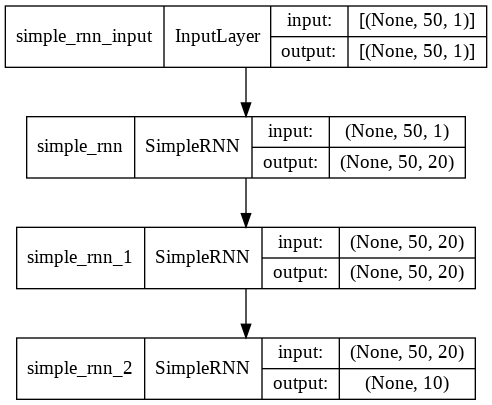

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [19]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30)

Epoch 1/30
219/219 [==============================] - 52s 221ms/step - loss: 0.0143 - val_loss: 9.8424e-04
Epoch 2/30
219/219 [==============================] - 48s 219ms/step - loss: 0.0012 - val_loss: 6.7063e-04
Epoch 3/30
219/219 [==============================] - 48s 218ms/step - loss: 8.7999e-04 - val_loss: 9.5360e-04
Epoch 4/30
219/219 [==============================] - 48s 218ms/step - loss: 7.4283e-04 - val_loss: 9.5405e-04
Epoch 5/30
219/219 [==============================] - 48s 221ms/step - loss: 6.6847e-04 - val_loss: 4.0579e-04
Epoch 6/30
219/219 [==============================] - 47s 217ms/step - loss: 5.2934e-04 - val_loss: 5.0390e-04
Epoch 7/30
219/219 [==============================] - 48s 219ms/step - loss: 5.4540e-04 - val_loss: 4.0074e-04
Epoch 8/30
219/219 [==============================] - 48s 220ms/step - loss: 4.6507e-04 - val_loss: 3.6971e-04
Epoch 9/30
219/219 [==============================] - 48s 221ms/step - loss: 4.4909e-04 - val_loss: 3.0033e-04
Epoch 10/

In [20]:
#Save the trained model to a h5 format file in the local directory.
model.save('model_rnn.h5', save_format='h5')

In [21]:
y_test.shape

(941, 10, 1)

##RMSE

In [22]:
y_pred_model = model.predict(X_test)

In [23]:
y_pred_model.shape

(941, 10)

In [24]:
y_pred_model = y_pred_model.reshape(-1,10,1)

In [25]:
y_pred_model.shape

(941, 10, 1)

In [26]:
rmse_model = np.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred_model)))
print("RMSE of model = ", rmse_model)

RMSE of model =  0.01682495


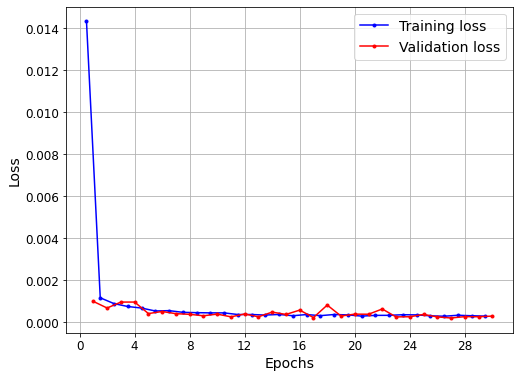

In [28]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

##Plot a window with predicted values

Modify `plot_series` to plot a window of data with predicted values. Note that the function has a new input: `step_ahead`.

In [77]:
def create_time_steps(length):
  return list(range(-length, 0))

In [84]:
create_time_steps(len(X_test[0]))

[-50,
 -49,
 -48,
 -47,
 -46,
 -45,
 -44,
 -43,
 -42,
 -41,
 -40,
 -39,
 -38,
 -37,
 -36,
 -35,
 -34,
 -33,
 -32,
 -31,
 -30,
 -29,
 -28,
 -27,
 -26,
 -25,
 -24,
 -23,
 -22,
 -21,
 -20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1]

In [81]:
def multi_step_plot(series, y, y_pred):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(series))
  num_out = len(y)

  plt.plot(num_in, np.array(series[:]), label='Series')
  plt.plot(np.arange(num_out)/STEP, np.array(y), 'bo',
           label='True')
  if y_pred.any():
    plt.plot(np.arange(num_out)/STEP, np.array(y_pred), 'ro',
             label='Prediction')
  plt.legend(loc='upper left')
  plt.show()

In [79]:
STEP = 1

In [74]:
X_test.shape

(941, 50, 1)

In [75]:
y_test.shape

(941, 10, 1)

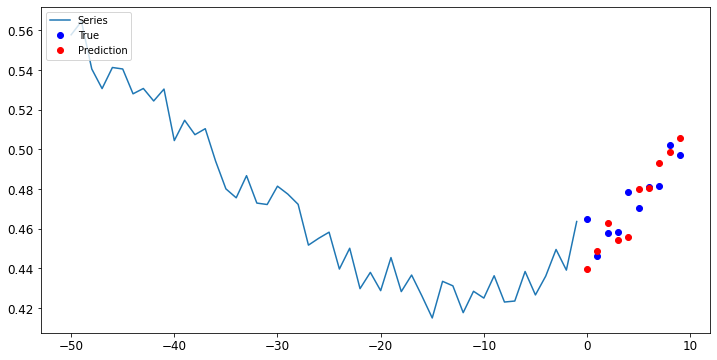

In [82]:
multi_step_plot(X_test[0], y_test[0], y_pred_model[0])